<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S6_ASSIGNMENT/3MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary

In [2]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       transforms.RandomRotation((-7.0,7.0),fill=(0))
                                       #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])

In [3]:
train = datasets.MNIST('./data', train=True,  download=True, transform=train_transforms)
test =  datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA Available? True


**Visualize the input data with image standardization**


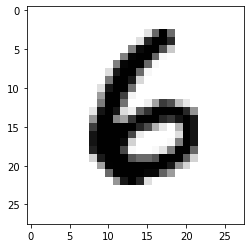

In [5]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

#print(images[0])
#print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

**Visualize the input data without image standardization**



In [6]:
#Comment this block from CODE2 onwards
#train_nonorm_transforms = transforms.Compose([
#                                       transforms.ToTensor()
#                                       #transforms.Normalize((0.1307,), (0.3081,))
#                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
#                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
#                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
#                                       ])
#test_nonorm_transforms  = transforms.Compose([
#                                       transforms.ToTensor()
#                                       #transforms.Normalize((0.1307,), (0.3081,))
#                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
#                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
#                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
#                                      ])
#train_nonorm = datasets.MNIST('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
#test_nonorm =  datasets.MNIST('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
#train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
#test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)
#dataiter_nonorm = iter(train_loader_nonorm)
#images, labels = dataiter_nonorm.next()
#print(images[0])
#print(labels.shape)
#
#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [ ]:
dropout_perc = 0.05

**####Batch Normalization + L1 LOSS**

In [65]:
class BatchNormNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

####LayerNorm Normalization + L1 LOSS

In [79]:
class LayerNormNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(10,0),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(18,0),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(16,0),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(20,0),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.GroupNorm(32,0),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

**`####Group normalization network + L1 LOSS`**

In [80]:
class GroupNormNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(10,2),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(18,2),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(16,2),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(20,2),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.GroupNorm(32,2),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [60]:
from tqdm import tqdm

l1_lamda = 0.0001

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            indices = []
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])

    test_loss = len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

**####Block to pass argment and call the Model**

Pass the model to be Inovoked based on Input Argument

The possibles values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

In [78]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BacthNormNet().to(device)
    plt.title('Model Type: Batch normalization')
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    plt.title('Model Type: Layer normalization')
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    plt.title('Model Type: Group normalization')
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS):
  summary(model, input_size=(1, 28, 28))
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test_fail_data = []
    test_fail_target = []
    test(model, device, test_loader)
  
  plt.xlabel('Test/Validation Loss Graph')
  plt.ylabel('LOSS')
  plt.plot(test_losses)

  plt.xlabel('Test/Validation Accuracy Graph')
  plt.ylabel('Accuracy')
  plt.plot(test_acc)

**####Plots for Test Loss / Accuracy**